In [34]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [35]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCH = 30

In [36]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            "../PlantVillage",
            shuffle = True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE 
           )

Found 2152 files belonging to 3 classes.


In [37]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [38]:
len(dataset)

68

In [39]:
# 68*BATCH_SIZE 

# 2176

In [40]:
# for image_batch, label_batch in dataset.take(1):
#     print(image_batch.shape)
#     print(label_batch.numpy())

# (32, 256, 256, 3)
# [1 0 0 0 0 1 1 0 0 1 1 1 1 2 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0]

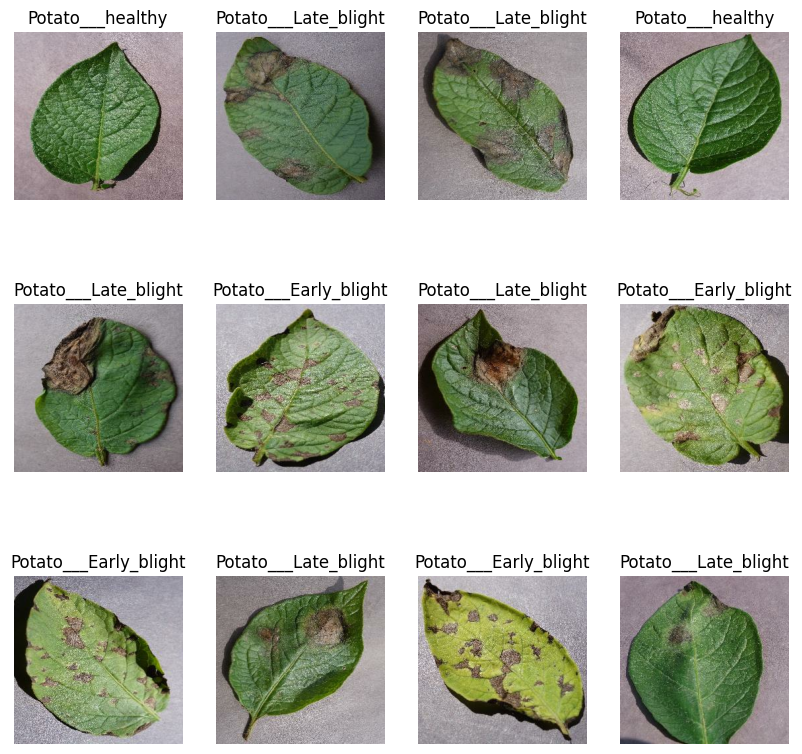

In [41]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [42]:
# 80% => Training
# 20% => 10% validation, 10% testing

In [43]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [44]:
train_ds = dataset.take(54) #raa[:54]
len(train_ds)

54

In [45]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [46]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [47]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [48]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [49]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
        ds_size = len(ds)

        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)
    
        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)

        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)
    
        return train_ds, val_ds, test_ds

In [50]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [51]:
len(train_ds)

54

In [52]:
len(val_ds)

6

In [53]:
len(test_ds)

8

In [54]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [55]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [56]:
# Data Augmentation -> If image is flip/rotate
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizonatal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [57]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3
model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape = input_shape)

In [58]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)     │ (32, 256, 256, 3)     │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ sequential_4 (Sequential)     │ (32, 256, 256, 3)     │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_6 (Conv2D)             │ (32, 254, 254, 32)    │          896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_6               │ (32, 127, 127, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_7 (Conv2D)             │ (32, 125, 125, 64)    │       18,496 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_7               │ (32, 62, 62, 64)      │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_8 (Conv2D)             │ (32, 60, 60, 64)      │       36,928 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_8               │ (32, 30, 30, 64)      │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_9 (Conv2D)             │ (32, 28, 28, 64)      │       36,928 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_9               │ (32, 14, 14, 64)      │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_10 (Conv2D)            │ (32, 12, 12, 64)      │       36,928 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_10              │ (32, 6, 6, 64)        │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_11 (Conv2D)            │ (32, 4, 4, 64)        │       36,928 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_11              │ (32, 2, 2, 64)        │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_1 (Flatten)           │ (32, 256)             │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_2 (Dense)               │ (32, 64)              │       16,448 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_3 (Dense)               │ (32, 3)               │          195 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [60]:
history = model.fit(
    train_ds,
    epochs = EPOCH,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 713ms/step - accuracy: 0.5449 - loss: 0.9158 - val_accuracy: 0.6458 - val_loss: 0.7948
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 757ms/step - accuracy: 0.7275 - loss: 0.6445 - val_accuracy: 0.7917 - val_loss: 0.4657
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 678ms/step - accuracy: 0.8385 - loss: 0.3932 - val_accuracy: 0.8594 - val_loss: 0.3110
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 662ms/step - accuracy: 0.8642 - loss: 0.3306 - val_accuracy: 0.8958 - val_loss: 0.2098
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 625ms/step - accuracy: 0.9058 - loss: 0.2525 - val_accuracy: 0.9427 - val_loss: 0.1575
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 637ms/step - accuracy: 0.9330 - loss: 0.1789 - val_accuracy: 0.9271 - val_loss: 0.1761
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 641ms/step - accuracy: 0.9449 - loss: 0.1602 - val_accuracy: 0.9479 - val_loss: 0.1601
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 775ms/step - accuracy: 0.9448 - loss: 0.1304 - val_accu

In [61]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.9541 - loss: 0.1731


In [62]:
scores

[0.12661071121692657, 0.95703125]

In [63]:
history

In [64]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [65]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

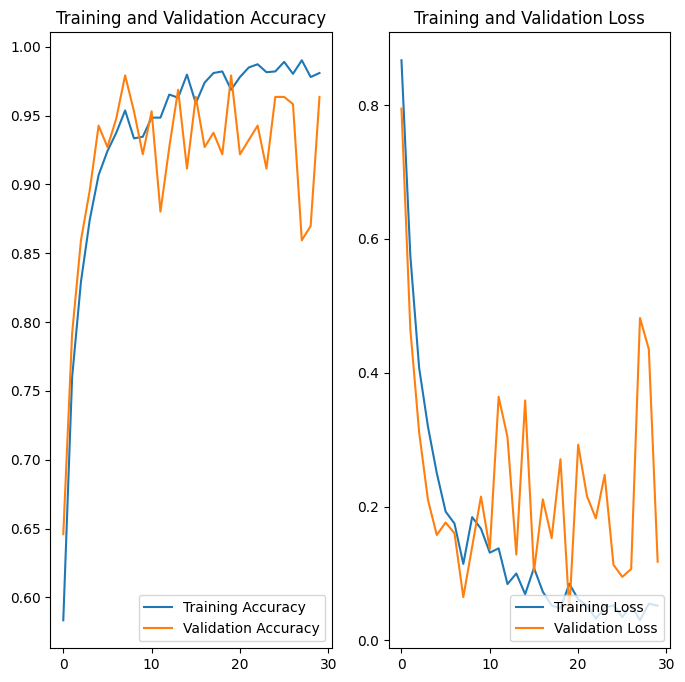

In [67]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label = 'Training Accuracy')
plt.plot(range(EPOCH), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), loss, label = 'Training Loss')
plt.plot(range(EPOCH), val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')

First image to predict


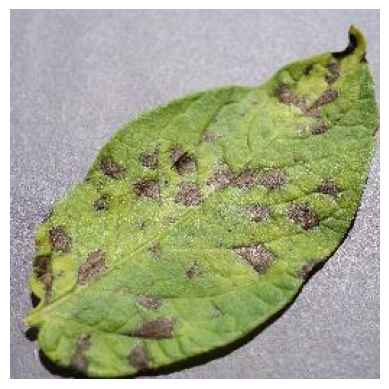

Actual Label :  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
Predicted Label :  Potato___Early_blight


In [68]:
import numpy as np

# Take one batch from the test dataset
for image_batch, label_batch in test_ds.take(1):
    # Get the first image and label in the batch
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    # Display the image
    print("First image to predict")
    plt.imshow(first_image)
    plt.axis('off')  # hides axis
    plt.show()

    # Print the actual label
    print("Actual Label : ", class_names[first_label])
    
    # Predict the label for the entire batch
    batch_prediction = model.predict(image_batch)
    
    # Get the predicted class of the first image
    predicted_class = np.argmax(batch_prediction[0])
    print("Predicted Label : ", class_names[predicted_class])

In [69]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, verbose=0)
    
    predicted_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_index]
    
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence

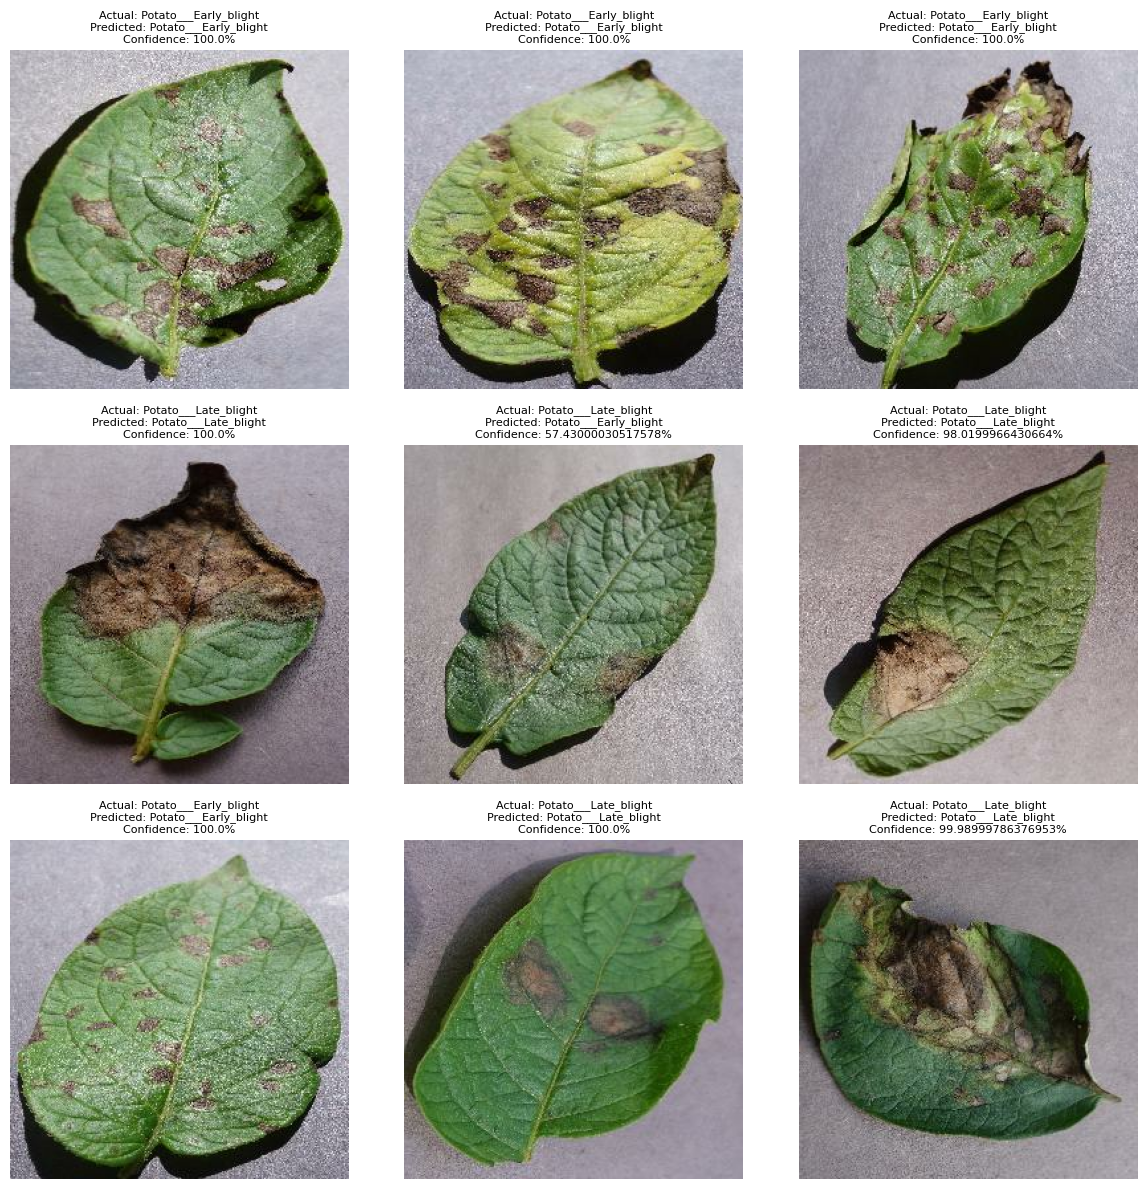

In [70]:
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i].numpy()]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%", fontsize=8)
        plt.axis("off")
        
plt.tight_layout()
plt.show()

In [74]:
import os
model_version = max([int(i) for i in os.listdir("../Store-Model") + [0]]) + 1
model.export(f"../Store-Model/{model_version}")

INFO:tensorflow:Assets written to: ../Store-Model/1\assets


INFO:tensorflow:Assets written to: ../Store-Model/1\assets


Saved artifact at '../Store-Model/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_24')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2998939069392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2998939070544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2998939071696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2998939072272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2998939072848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2998939073424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2998939072656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2998939074192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2998939073616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2998939074384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2998939071120: TensorSpec(shape